- Add Ethiopia
- Simplify / comment code

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import cfgrib
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from cdo import *
cdo = Cdo()

## Functions

In [2]:
def load_data(country_code):


    #Define input data path
    file_path_start = './data/' 
    #ERA 5
    file_name_era5_start = 'era5-monthly-seasonal-forecast-total-precipitation'
    file_path_era5 = file_path_start + file_name_era5_start + '-1981-2023-'+ country_code +'.grib'
    file_path_era5_1deg = file_path_start + file_name_era5_start + '-1981-2023-' + country_code + '_1deg.grib'
    #ECMWF
    file_name_ecmwf_start = 'ecmwf-monthly-seasonalforecast-1981-2023-' + country_code +'.grib'
    file_path_ecmwf = file_path_start + file_name_ecmwf_start

    ds_ecmwf = xr.open_dataset(file_path_ecmwf, engine="cfgrib")
    input_ecmwf_df = ds_ecmwf.to_dataframe().dropna().reset_index()

    if False: #to do: add check to see if low-resolution for ERA5 is available
        cdo.remapcon(file_path_ecmwf,input = file_path_era5, output = file_path_era5_1deg, force =  False)

    ds_era5 = xr.open_dataset(file_path_era5_1deg, engine="cfgrib")
    input_era5_df = ds_era5.to_dataframe().dropna().reset_index()

    return input_ecmwf_df, input_era5_df

In [3]:
def pre_process_data(input_df, data_source):

    output_col = ['date_year','date_month','lead_time','latitude','longitude','tp_mm_day']
    
    if (data_source == 'ecmwf'): 
        output_col = ['number'] + output_col
    
    #format data
    df = input_df.copy()
    #rounding resolution here because the grid interpolation doesn't give exact results. Should improve this by some other method 
    df['latitude'] = df['latitude'].apply(lambda x : round(x,2))
    df['longitude'] = df['longitude'].apply(lambda x : round(x,2))
    df.rename(columns={"tprate": "tp_mm_day", "tp": "tp_mm_day"}, inplace = True, errors= 'ignore')
    
    
    #Compute lead time in months for ecmwf
    if (data_source == 'ecmwf'): 
        df['lead_time'] = 0
        for lead_days in df['step'].unique():
            lead_months = round(float(str(lead_days).split(" ")[0])/30)
            df.loc[df['step'] == lead_days, 'lead_time'] = lead_months
    else:
        df['lead_time'] = 0
        
    
    #Correct valid time convention. ERA5 shift comes from the CDO grid matching, not sure why
    df['date_year'] = df['valid_time'].apply(lambda x : x.year)
    if (data_source == 'ecmwf'): 
        df['date_month'] = df['valid_time'].apply(lambda x : x.month-1)
        df.loc[df['date_month'] == 0, 'date_month'] = 12
    else:
        df['date_month'] = df['valid_time'].apply(lambda x : x.month+1)
        df.loc[df['date_month'] == 13, 'date_month'] = 1
        
    
    
    #Each source use a different unit (meters/day for ERA5 and meters/second for ECMWF). Converting both on mm/day here
    if (data_source == 'ecmwf'):
        df['tp_mm_day'] = df['tp_mm_day']*1000*60*60*24
    else:
        df['tp_mm_day'] = df['tp_mm_day']*1000
    
    df = df[output_col]


    return(df)

    

In [4]:

def ecmwf_bias_correction(ecmwf_df,era5_df):

    
    ecmwf_corr_df = ecmwf_df.copy()

    era5_avg_df = era5_df.groupby(['latitude','longitude','date_month'])['tp_mm_day'].mean().reset_index()

    ecmwf_avg_df = ecmwf_df.groupby(['number','latitude','longitude','date_month','lead_time'])[['tp_mm_day']].mean().reset_index()

    avg_df = pd.merge(ecmwf_avg_df, era5_avg_df, on=['date_month','latitude','longitude'], suffixes=('_ecmwf', '_era5'))
    avg_df['bias'] = avg_df['tp_mm_day_ecmwf'] - avg_df['tp_mm_day_era5']
    avg_df.drop(['tp_mm_day_ecmwf','tp_mm_day_era5'], inplace = True, axis = 1)
                
    ecmwf_corr_df = pd.merge(ecmwf_corr_df, avg_df, on=['number','date_month','latitude','longitude','lead_time'])
    ecmwf_corr_df['tp_mm_day'] = ecmwf_corr_df['tp_mm_day'] - ecmwf_corr_df['bias']
    ecmwf_corr_df.loc[ecmwf_corr_df['tp_mm_day'] < 0, 'tp_mm_day'] = 0
    ecmwf_corr_df.drop(['bias'], inplace = True, axis = 1)

    return(ecmwf_corr_df)



In [5]:
def create_geom_hash_id(df, drop_col):
    
    if 'latitude' in df.columns.values:
        df['geom_id'] = df['latitude'].astype('str') + '-' + df['longitude'].astype('str') 
        df['geom_id'] = df['geom_id'].apply(lambda x: hash(x))
        if drop_col == True:
            df.drop(columns = ['latitude','longitude'], inplace = True)
        

    return(df)

In [6]:
def create_grid_df(df):
    grid_df = df[['latitude','longitude']].copy()
    grid_df.drop_duplicates(inplace = True)
    grid_df.reset_index(drop = True, inplace = True)
    grid_df = create_geom_hash_id(grid_df, drop_col = False)
    
    grid_df = gpd.GeoDataFrame(
        grid_df, geometry=gpd.points_from_xy(grid_df.longitude, grid_df.latitude), crs="EPSG:4326"
    )

    return(grid_df)

In [7]:
def compute_era5_climatology(era5_df):
    
    climatology_era5_df = era5_df.groupby(['geom_id','date_month']).agg(
        era5_avg = ('tp_mm_day',  lambda x: x.mean()),
        era5_q2 = ('tp_mm_day',  lambda x: x.quantile(1/2)),
        era5_q3 = ('tp_mm_day',  lambda x: x.quantile(1/3)),
        era5_q4 = ('tp_mm_day',  lambda x: x.quantile(1/4)),
        era5_q5 = ('tp_mm_day',  lambda x: x.quantile(1/5))).reset_index()


    return(climatology_era5_df)



In [8]:
def compute_quantile_probability(pred_df, climatology_era5_df):
    
    prob_df = pred_df.copy()

    prob_df = pd.merge(prob_df, climatology_era5_df, on=['date_month','geom_id'])

    prob_df['prob_q2'] = prob_df['tp_mm_day'] <= prob_df['era5_q2']
    prob_df['prob_q3'] = prob_df['tp_mm_day'] <= prob_df['era5_q3']
    prob_df['prob_q4'] = prob_df['tp_mm_day'] <= prob_df['era5_q4']
    prob_df['prob_q5'] = prob_df['tp_mm_day'] <= prob_df['era5_q5']
  
    prob_df = prob_df.groupby(['date_year','date_month','lead_time','geom_id'])[['tp_mm_day','prob_q2','prob_q3','prob_q4','prob_q5','era5_q2']].mean().reset_index()

    return(prob_df)
    

In [9]:
def create_link_df(grid_df, country_code):

    admin1_input_df = gpd.read_file('./data/geoBoundariesCGAZ_ADM1.geojson', driver='GeoJSON')
    admin1_df = admin1_input_df[admin1_input_df['shapeGroup'].isin(country_code)].reset_index(drop = True)
    admin1_df.rename(columns = {'shapeID' : 'geom_id'}, inplace = True)
    
    link_df = admin1_df.sjoin(grid_df, how="inner", predicate='intersects')
    link_df.rename(columns = {'geom_id_left' : 'geom_id_admin', 'geom_id_right' : 'geom_id_grid'}, inplace = True)

    return(link_df)

In [10]:
def aggregate_admin_level(df, link_df):
    
    df = pd.merge(df, link_df[['geom_id_grid','geom_id_admin']], left_on = 'geom_id', right_on = 'geom_id_grid')
    df.drop(columns = ['geom_id', 'geom_id_grid'], inplace = True)
    df.rename(columns = {'geom_id_admin':'geom_id'}, inplace = True)

    list_col = list(df.columns.values)
    list_col.remove('tp_mm_day')
    df = df.groupby(list_col)['tp_mm_day'].mean().reset_index()

    return(df)

## Data Processing

In [11]:
## tcd / cenam
country_code = 'cenam'
input_ecmwf_df, input_era5_df = load_data(country_code)


In [12]:
ecmwf_df = pre_process_data(input_ecmwf_df, 'ecmwf')
era5_df = pre_process_data(input_era5_df, 'era5')

grid_df = create_grid_df(ecmwf_df)

ecmwf_corr_df = ecmwf_bias_correction(ecmwf_df,era5_df)

ecmwf_corr_df = create_geom_hash_id(ecmwf_corr_df, drop_col = True)
ecmwf_df = create_geom_hash_id(ecmwf_df, drop_col = True)
era5_df = create_geom_hash_id(era5_df, drop_col = True)

In [13]:
admin_level_analysis = True


country_code = ['blz','cri','slv','gtm','hnd','nic','pan']
country_code = [element.upper() for element in country_code] 

if admin_level_analysis:
    link_df = create_link_df(grid_df, country_code)
    ecmwf_corr_df = aggregate_admin_level(ecmwf_corr_df, link_df)
    ecmwf_df = aggregate_admin_level(ecmwf_df, link_df)
    era5_df = aggregate_admin_level(era5_df, link_df)

In [14]:
era5_df.head()

,date_year,date_month,lead_time,geom_id,tp_mm_day
0,1980,1,0,10453824B23677570544502,0.917400
1,1980,1,0,10453824B24427405220616,0.241126
2,1980,1,0,10453824B33911095974475,2.816762
3,1980,1,0,10453824B47889694645812,1.217927
4,1980,1,0,10453824B59135534570849,0.272120


In [15]:
climatology_era5_df = compute_era5_climatology(era5_df)

ecmwf_corr_pred_df = compute_quantile_probability(ecmwf_corr_df, climatology_era5_df)
ecmwf_pred_df = compute_quantile_probability(ecmwf_df, climatology_era5_df)
era5_df = compute_quantile_probability(era5_df, climatology_era5_df)

In [16]:
country_code = 'cenam'

ecmwf_corr_pred_df.to_csv('./temp/ecmwf_corr_df_'+country_code+'.csv')
ecmwf_pred_df.to_csv('./temp/ecmwf_df_'+country_code+'.csv')
era5_df.to_csv('./temp/era5_df_'+country_code+'.csv')


In [17]:
country_code = ['blz','cri','slv','gtm','hnd','nic','pan']
country_code = [element.upper() for element in country_code] 

admin1_input_df = gpd.read_file('./data/geoBoundariesCGAZ_ADM1.geojson', driver='GeoJSON')
admin1_df = admin1_input_df[admin1_input_df['shapeGroup'].isin(country_code)].reset_index(drop = True)

country_df = era5_df.groupby('geom_id')['tp_mm_day'].mean().reset_index()
pd.merge(admin1_df, country_df, left_on = 'shapeID', right_on = 'geom_id').to_file('./temp/cenam_country_era5_average_per_grid.geojson', driver="GeoJSON")  


In [18]:
pd.merge(admin1_df, country_df, left_on = 'shapeID', right_on = 'geom_id').to_file('./temp/cenam_country_era5_average_per_grid.geojson', driver="GeoJSON")  


## Analysis

In [19]:
def plot_climatology(era5_df, ecmwf_df):

    era5_month_df = era5_df.groupby('date_month')['tp_mm_day'].mean().reset_index()
    ecmwf_month_df = ecmwf_df.groupby(['lead_time','date_month'])['tp_mm_day'].mean().reset_index()
    
    fig,ax = plt.subplots()
    
    
    ax.plot(era5_month_df.date_month,era5_month_df.tp_mm_day, label = 'era5')
    for i in range(1,7):
        ecmwf_month_df_plot = ecmwf_month_df[ecmwf_month_df['lead_time'] == i]
        ax.plot(ecmwf_month_df_plot.date_month,ecmwf_month_df_plot.tp_mm_day, label = 'lead_time: ' + str(i))
    
    ax.set_title('Precipitation bias per month and lead time (country average)')
    ax.set_xlabel("month")
    ax.set_ylabel("precipitation bias (mm / day)")
    
    ax.legend(loc='best')

    return

In [80]:
def plot_leadtime_month_dependency(merge_df, merge_corr_df):
    
    #fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 18))
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 6))

    row = 0
    for col in range(2):     

        ax = axs[col]
        score_df = merge_df.groupby(['lead_time_ecmwf','date_month'])[['bias','mae']].mean().reset_index()
        plot_df = score_df.groupby('lead_time_ecmwf')[['bias','mae']].mean().reset_index()
        
        score_corr_df = merge_corr_df.groupby(['lead_time_ecmwf','date_month'])[['bias','mae']].mean().reset_index()
        plot_corr_df = score_corr_df.groupby('lead_time_ecmwf')[['bias','mae']].mean().reset_index()
        
        if col == 0:
            ax.plot(plot_df['lead_time_ecmwf'],plot_df.bias, label = 'Before bias correction')
            ax.plot(plot_corr_df['lead_time_ecmwf'],plot_corr_df.bias, label = 'After bias correction')
            ax.set_title('Bias evolution with lead time')
            ax.set_ylabel("Bias (mm/day)")
            ax.set_ylim([min(-0.1,1.1*plot_df.bias.min(),1.1*plot_corr_df.bias.min()),max(0.1,1.1*plot_df.bias.max(),1.1*plot_corr_df.bias.max())])
        else:
            ax.plot(plot_df['lead_time_ecmwf'],plot_df.mae, label = 'Before bias correction')
            ax.plot(plot_corr_df['lead_time_ecmwf'],plot_corr_df.mae, label = 'After bias correction')
            ax.set_ylabel("MAE (mm/day)")
            ax.set_ylim([-0.1,max(1.1*plot_df.mae.max(),1.1*plot_corr_df.mae.max())])
                                     
        
        ax.set_xlabel('lead time')
        ax.legend(loc='best')

    return

In [74]:
country_code = 'cenam'
month_range = [6,7,8,9,10]


ecmwf_df = pd.read_csv('./temp/ecmwf_df_'+country_code+'.csv')
ecmwf_corr_df = pd.read_csv('./temp/ecmwf_corr_df_'+country_code+'.csv')
era5_df = pd.read_csv('./temp/era5_df_'+country_code+'.csv')



In [82]:



score_df = pd.merge(ecmwf_df, era5_df, on=['date_year','date_month','geom_id'], suffixes=('_ecmwf', '_era5'))
score_df['bias'] = score_df['tp_mm_day_ecmwf'] -  score_df['tp_mm_day_era5']
score_df['mae'] = abs(score_df['bias'])
score_df = score_df[score_df.era5_q2_era5 > 0]

score_corr_df = pd.merge(ecmwf_corr_df, era5_df, on=['date_year','date_month','geom_id'], suffixes=('_ecmwf', '_era5'))
score_corr_df['bias'] = score_corr_df['tp_mm_day_ecmwf'] -  score_corr_df['tp_mm_day_era5']
score_corr_df['mae'] = abs(score_corr_df['bias'])
score_corr_df = score_corr_df[score_corr_df.era5_q2_era5 > 0]

score_df = score_df[score_df['date_month'].isin(month_range)]
score_corr_df = score_corr_df[score_corr_df['date_month'].isin(month_range)]


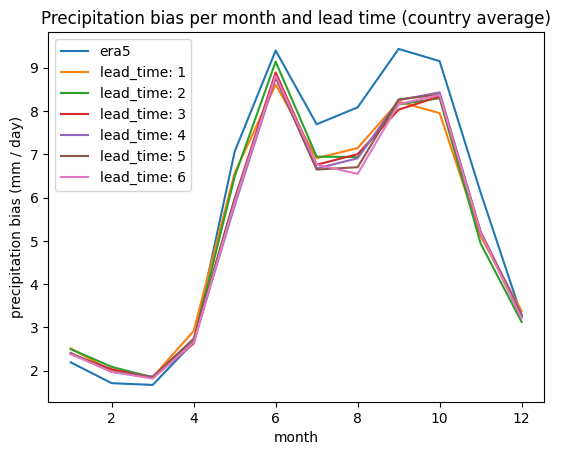

In [83]:
plot_climatology(era5_df, ecmwf_df)

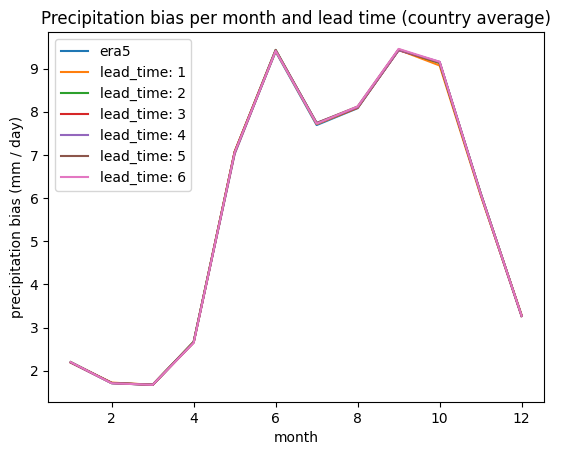

In [84]:
plot_climatology(era5_df, ecmwf_corr_df)

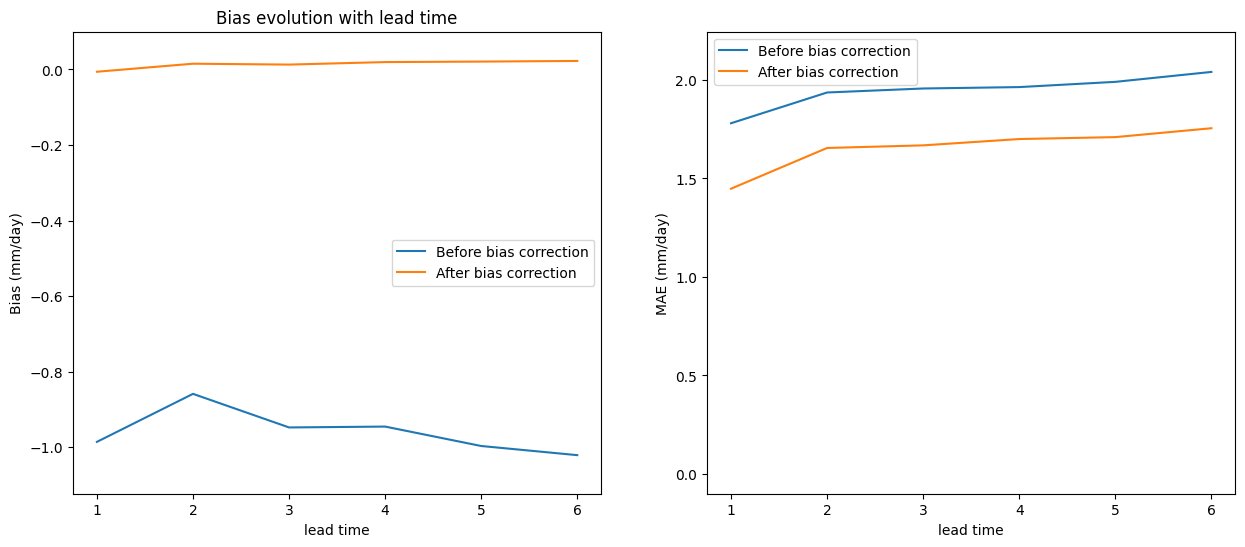

In [85]:
plot_leadtime_month_dependency(score_df, score_corr_df)


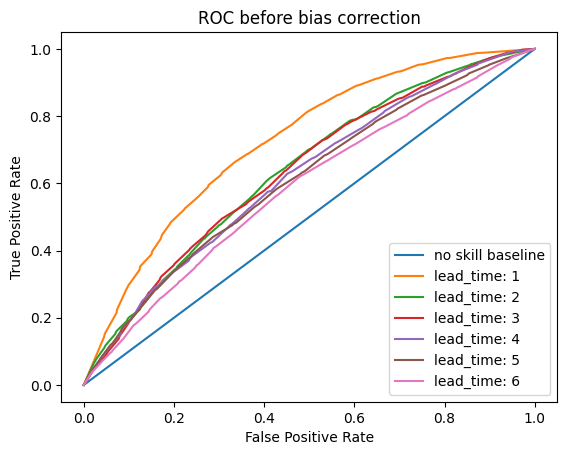

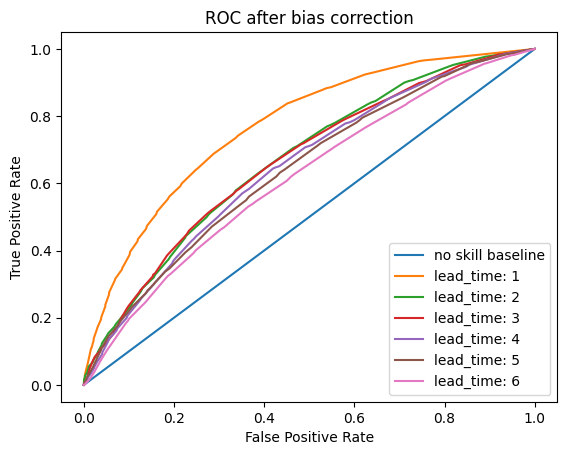

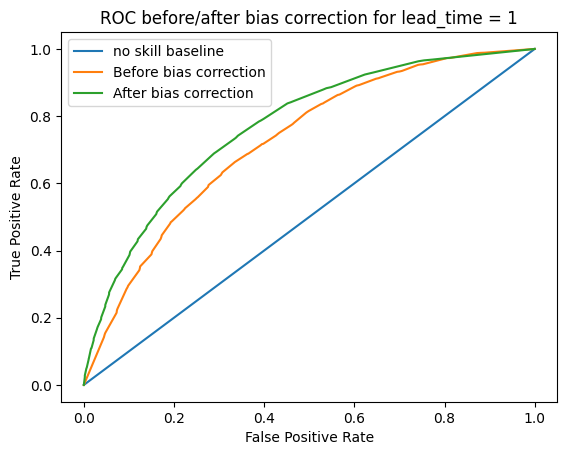

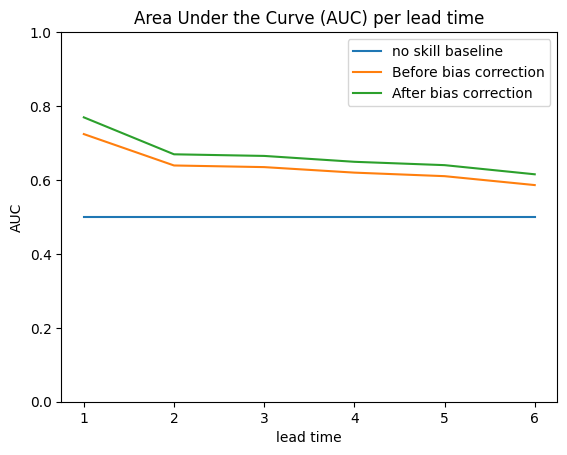

In [86]:

lead_time = [1,2,3,4,5,6]
auc_before_bias = []
auc_after_bias = []

q = '3'

############################

df = score_df[score_df['lead_time_ecmwf'] == 1]
fpr, tpr, thresholds = metrics.roc_curve(df['prob_q'+q+'_era5'], df['prob_q'+q+'_ecmwf'])

plt.plot(fpr,fpr, label = 'no skill baseline')

for i in range(1,7):
    df = score_df[score_df['lead_time_ecmwf'] == i]
    fpr, tpr, thresholds = metrics.roc_curve(df['prob_q'+q+'_era5'], df['prob_q'+q+'_ecmwf'])
    auc_before_bias.append(metrics.auc(fpr,tpr))
    plt.plot(fpr,tpr, label = 'lead_time: ' + str(i))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.title('ROC before bias correction')
plt.show()

############################

plt.plot(fpr,fpr, label = 'no skill baseline')

for i in range(1,7):
    df = score_corr_df[score_corr_df['lead_time_ecmwf'] == i]
    fpr, tpr, thresholds = metrics.roc_curve(df['prob_q'+q+'_era5'], df['prob_q'+q+'_ecmwf'])
    auc_after_bias.append(metrics.auc(fpr,tpr))
    plt.plot(fpr,tpr, label = 'lead_time: ' + str(i))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.title('ROC after bias correction')
plt.show()



############################

plt.plot(fpr,fpr, label = 'no skill baseline')


df = score_df[score_df['lead_time_ecmwf'] == 1]
fpr, tpr, thresholds = metrics.roc_curve(df['prob_q'+q+'_era5'], df['prob_q'+q+'_ecmwf'])
plt.plot(fpr,tpr, label = 'Before bias correction')

df = score_corr_df[score_corr_df['lead_time_ecmwf'] == 1]
fpr, tpr, thresholds = metrics.roc_curve(df['prob_q'+q+'_era5'], df['prob_q'+q+'_ecmwf'])
plt.plot(fpr,tpr, label = 'After bias correction')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.title('ROC before/after bias correction for lead_time = 1')
plt.show()




############################


plt.plot([1,6],[0.5,0.5], label = 'no skill baseline')
plt.plot(lead_time,auc_before_bias, label = 'Before bias correction')
plt.plot(lead_time,auc_after_bias, label = 'After bias correction')

plt.ylabel('AUC')
plt.xlabel('lead time')
plt.legend(loc='best')
plt.title('Area Under the Curve (AUC) per lead time')
plt.ylim([0,1])
plt.show()


## Sandbox